In [1]:
from IPython.display import Image, display
from PIL import Image, ImageDraw, ImageFont
import PIL
from classes import *
from test_classes import *
import random
from core import *

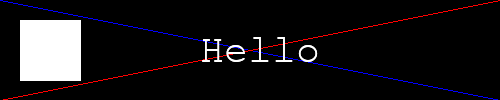

In [2]:
im = Image.new('RGBA', (500,100), color='black')
draw = ImageDraw.Draw(im)

fnt = ImageFont.truetype('Pillow/Tests/fonts/FreeMono.ttf', 40)

draw.line((0, 0) + im.size, fill='blue')
draw.line((0, im.size[1], im.size[0], 0), fill='red')
draw.text((200,30), "Hello", font=fnt, fill=(255,255,255,0))
draw.rectangle((80,80,20,20), fill='white')
del draw

# write to stdout
display(im)

In [39]:
fnt = ImageFont.truetype('FreeMonoBold.ttf', 12)
def draw_pieces(pieces, perspective=None, width=800, height=30):
    im = Image.new('RGB', (width, height), color='white')
    d = ImageDraw.Draw(im)
    '''
    translates an absolute cake coordinate into a screen coordinate, and also through the perspective of
    an agent's value function if that is specified
    '''
    def xcoord(x):
        if perspective==None:
            return x*width
        else:
            return perspective.value_up_to(x) * width
    for p in pieces:
        
        t = p.get_rightmost_trim()
        if t != None:
            left = xcoord( p.intervals[0].left )
            #TODO better do something about this if there are multiple
            right = xcoord( t.x )
            d.rectangle((left,1,right-1,height-2), fill=(250,200,210), outline=(200,150,150))
        
        #draw outlines of piece
        #draw divisions of piece
        for interval in p.intervals:
            left = xcoord( interval.left )
            right= xcoord( interval.right )
            d.rectangle((left,1,right-1,height-2), outline='black')
            if p.allocated != None:
                d.text((right - 40, 0 + 3), str(p.allocated)[6:], fill='black', font=fnt)
    display(im)
    
def draw_preferences(agent, width=800, height=60):
    im = Image.new('RGB', (width, height), color='white')
    d = ImageDraw.Draw(im)
    highest = max([agent.adv[k] for k in agent.adv])
    height_factor = height / highest
    bar_width = width / len(agent.adv)
    x=0
    for k in agent.adv:
        d.rectangle((x, 
                     height - agent.adv[k]*height_factor,
                     x+bar_width,
                     height), fill=(180,200,245), outline='blue')
        x += bar_width
    d.text((3, 3), str(agent)[6:] + ' preferences', fill='black', font=fnt)
    display(im)
    

In [8]:
agents = [Agent(random.randint(5,23)) for i in range(5)]
cake = Cake()
pieces = core(agents[0], agents, cake.pieces[0])

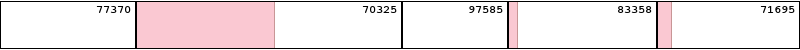

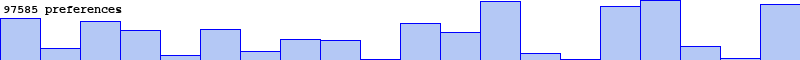

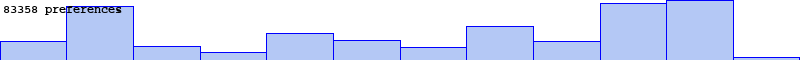

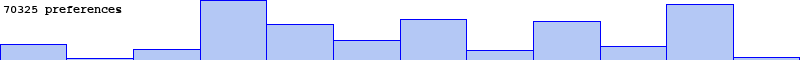

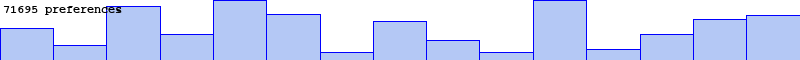

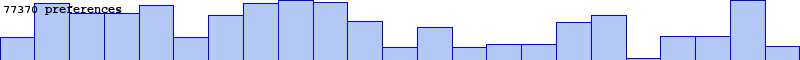

In [40]:
draw_pieces(pieces, height=50)
for a in agents:
    draw_preferences(a)
    draw_pieces(pieces, perspective=a)